In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

In [3]:
# load bochum data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

In [11]:
# load the RPN-signature (trained on sample 1):
# load trained finalized models
model_bochum = joblib.load('model_trained_on_bochum.joblib') #RPN-signature
model_essen = joblib.load('model_trained_on_essen.joblib')
model_szeged = joblib.load('model_trained_on_szeged.joblib') 

model_bochum_essen = joblib.load('model_trained_on_bochum+essen.joblib')
model_bochum_szeged = joblib.load('model_trained_on_bochum+szeged.joblib')
model_essen_szeged = joblib.load('model_trained_on_essen+szeged.joblib') 

model_bochum_essen_szeged = joblib.load('model_trained_on_all.joblib') 

models = {
    'study1': model_bochum,
    'study2': model_essen,
    'study3': model_szeged,
    'study1+2': model_bochum_essen,
    'study1+3': model_bochum_szeged,
    'study2+3': model_essen_szeged,
    'study1+2+3': model_bochum_essen_szeged
}


In [12]:
#get region names from an arbitrary timeseries file
ts = pd.read_csv('../data/bochum-sample/regional_timeseries/bochum-023_pumi-17-scrubbed.tsv').iloc[:,1:] 
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

# function to extract predictive weights:
def get_weights(model, labels=labels, modules=modules):
    RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

    featuremask = model.named_steps['fsel'].get_support()
    RES[featuremask] = model.named_steps['model'].coef_
    
    RES_MAT = vec_to_sym_matrix(RES, diagonal=np.repeat(0, len(labels)))
    return RES_MAT
    

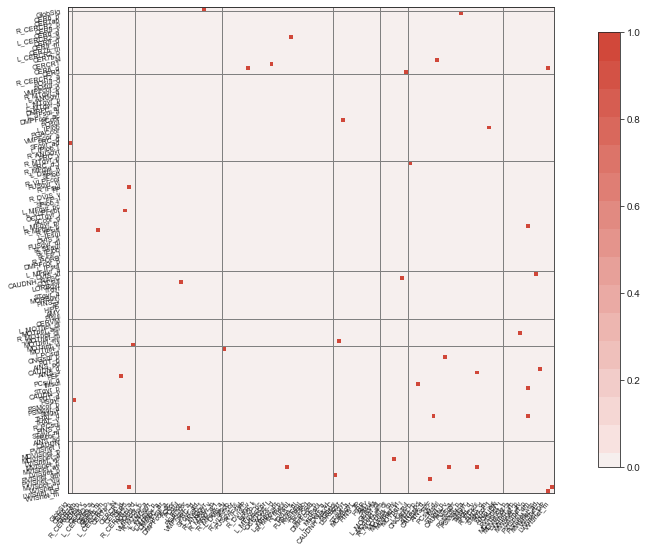

In [13]:
plot.plot_matrix(get_weights(models['study1'])!=0, labels, modules)

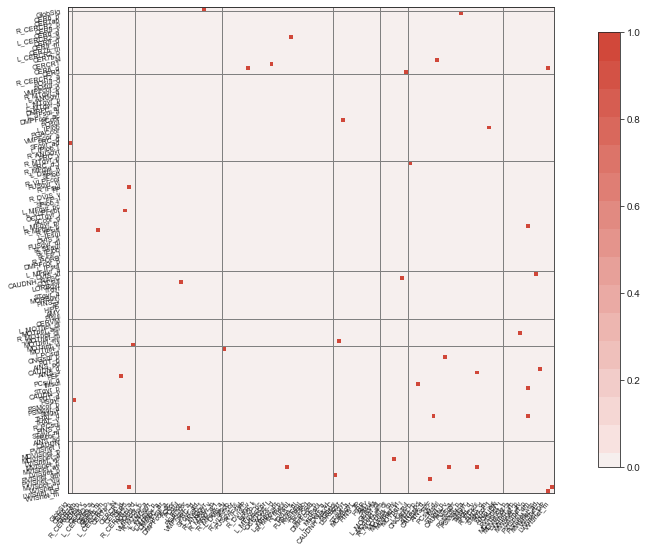

In [15]:
res = np.zeros_like(get_weights(models['study1']))

for m in models:
    binarized = np.array(get_weights(models[m])!=0, dtype=int)
    res += binarized

plot.plot_matrix(get_weights(models['study1'])!=0, labels, modules)